In [45]:
import numpy as np
import matplotlib.pyplot as plt

In this quick simulation, I want to figure out for a fixed sequencing depth, should it be split between a lot of insertion sites in a gene and averaged, or should we sequence fewer sites in a gene at high depth

In [46]:
sites1 = 10**5
sites2 = 10**4
reads = 10**6

Let's consider a gene with 100 insertion sites. In scenario 1, all 100 are represented in sequencing data, in scenario 2, only 10 are represented

In [85]:
coverage1 = 25
coverage2 = 62.5

In [157]:
n1 = 60
n2 = 24

In [158]:
#quick and dirty error estimate
e1 = 1/6.64/np.sqrt(n1)*np.log((coverage1+np.sqrt(coverage1))/(coverage1-np.sqrt(coverage1)))
e2 = 1/6.64/np.sqrt(n2)*np.log((coverage2+np.sqrt(coverage2))/(coverage2-np.sqrt(coverage2)))
print(e1)
print(e2)

0.007883331381381076
0.007818955519999038


Assume that the mutating the gene has no effect. So any noise should purely be Poisson noise

In [256]:
sc1_t0 = np.random.poisson(coverage1, n1)
#sc1_t1 = np.random.poisson(coverage1, n1)
sc2_t0 = np.random.poisson(coverage2, n2)
#sc2_t1 = np.random.poisson(coverage2, n2)
sc1_t1 = np.zeros(n1)
sc2_t1 = np.zeros(n2)
for i in range(0, n1):
    sc1_t1[i] = np.random.poisson(sc1_t0[i])
for i in range(0, n2):
    sc2_t1[i] = np.random.poisson(sc2_t0[i])

Now let's calculate fitness in these two scenarios

In [257]:
fitness_sc1 = np.log(sc1_t1/sc1_t0*np.sum(sc1_t0)/np.sum(sc1_t1))/6.64
fitness_sc2 = np.log(sc2_t1/sc2_t0*np.sum(sc2_t0)/np.sum(sc2_t1))/6.64

Now let's look at the means and standard deviations of the fitness estimates for the same gene in the two scenarios

In [258]:
print(np.mean(fitness_sc1))
print(np.std(fitness_sc1)/np.sqrt(60))

-0.0042763727054895674
0.00480223176477605


In [259]:
print(np.mean(fitness_sc2))
print(np.std(fitness_sc2)/np.sqrt(24))

-0.0013341801278724523
0.00402905970055348


Text(0, 0.5, 'counts')

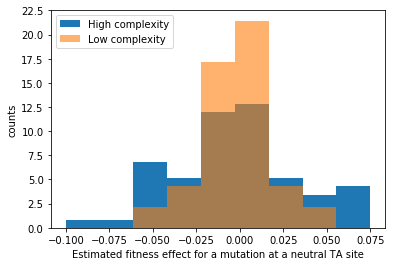

In [165]:
plt.hist(fitness_sc1, bins=np.linspace(-0.1, 0.075, 10), label='High complexity', density=True)
plt.hist(fitness_sc2, bins=np.linspace(-0.1, 0.075, 10), label='Low complexity', density=True, alpha=0.6)
plt.xlabel("Estimated fitness effect for a mutation at a neutral TA site")
plt.legend(loc=0)
plt.ylabel("counts")

## Now, let's play around with initial library complexity and see how that affects the variation in fitness estimates

In [56]:
complexity = np.linspace(2*10**4, 10**6, 200)

In [57]:
#these are the proportion of unique TA sites represented in the sequencing data on average
fraction_sites = 1 - np.exp(-complexity/211995)

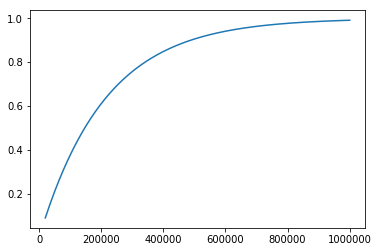

In [58]:
plt.plot(complexity, fraction_sites)

In [59]:
#number of sites represented in a gene
n_gene = np.round(fraction_sites*60)

In [60]:
#number of reads (for an entire library)
n_reads = 5*10**6
rps = n_reads/fraction_sites/211995

In [61]:
errors = 1/6.64/np.sqrt(n_gene)*np.log((rps+np.sqrt(rps))/(rps-np.sqrt(rps)))

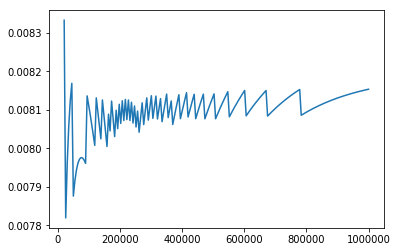

In [62]:
plt.plot(complexity, errors)

let's try to generate the same plot without the weird squiggles due to rounding off 

In [68]:
#let's stick to a linearly spacing in terms of number of sites represented per gene
n_genes1 = np.linspace(1,59,59)
#now, I'll infer a complexity of transposon library which leads to representing these many genes
complexity1 = -np.log(1-n_genes1/60)*211995

In [69]:
complexity1

array([  3563.02504748,   7186.95944749,  10873.92194369,  14626.14379088,
        18445.97686492,  22335.90251688,  26298.54125479,  30336.6633476 ,
        34453.20045888,  38651.25843253,  42934.13137031,  47305.31716086,
        51768.53464375,  56327.74261957,  60987.16094942,  65751.29402577,
        70624.95694182,  75613.30474029,  80721.86518729,  85956.57559339,
        91323.82429702,  96830.49753708, 102484.03257726, 108292.47811027,
       114264.56317283, 120409.77605227, 126738.45497519, 133261.89275425,
       139992.45805345, 146943.73654281, 154130.69599029, 161569.88033368,
       169279.63905969, 177280.39989041, 185594.99497534, 194249.05370366,
       203271.47916237, 212695.03056858, 222557.0412831 , 232900.3121362 ,
       243774.23407988, 255236.21465308, 267353.51259508, 280205.62929705,
       293887.47308561, 308513.61687649, 324224.13643322, 341192.79024647,
       359638.76711138, 379844.048679  , 402179.95119588, 427149.36583986,
       455457.35341929, 4

In [70]:
#reads per site
rps1 = n_reads*60/n_genes1/211995

array([1415.12771528,  707.56385764,  471.70923843,  353.78192882,
        283.02554306,  235.85461921,  202.16110218,  176.89096441,
        157.23641281,  141.51277153,  128.64797412,  117.92730961,
        108.8559781 ,  101.08055109,   94.34184769,   88.4454822 ,
         83.24280678,   78.6182064 ,   74.48040607,   70.75638576,
         67.38703406,   64.32398706,   61.52729197,   58.9636548 ,
         56.60510861,   54.42798905,   52.4121376 ,   50.54027555,
         48.79750742,   47.17092384,   45.64928114,   44.2227411 ,
         42.88265804,   41.62140339,   40.43222044,   39.3091032 ,
         38.24669501,   37.24020303,   36.28532603,   35.37819288,
         34.51531013,   33.69351703,   32.90994687,   32.16199353,
         31.44728256,   30.76364598,   30.10910033,   29.4818274 ,
         28.88015745,   28.30255431,   27.74760226,   27.21399452,
         26.70052293,   26.2060688 ,   25.72959482,   25.27013777,
         24.82680202,   24.39875371,   23.98521551])

In [73]:
errors1 = 1/6.64/np.sqrt(n_genes1)*np.log((rps1+np.sqrt(rps1))/(rps1-np.sqrt(rps1)))

Text(0, 0.5, 'error in sequencing')

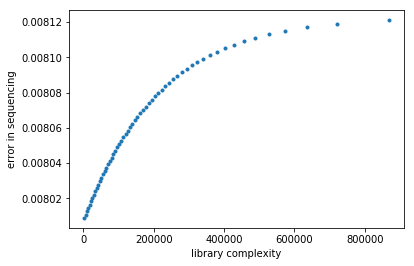

In [76]:
plt.plot(complexity1, errors1, '.')
plt.xlabel("library complexity")
plt.ylabel("error in sequencing")

### Let's try drawing number of reads from an exponential distribution, instead of a Poisson!

doing the same as Poisson distribution will not do! Use exponential distribution for t0, use the value as mean for Poisson for t1

In [245]:
n1 = 60
n2 = 24

In [246]:
sc1_t0_exp = np.random.exponential(coverage1, n1)
#sc1_t1_exp = np.random.exponential(coverage1, n1)
sc2_t0_exp = np.random.exponential(coverage2, n2)
#sc2_t1_exp = np.random.exponential(coverage2, n2)
sc1_t1_exp = np.zeros(n1)
sc2_t1_exp = np.zeros(n2)
for i in range(0, n1):
    sc1_t1_exp[i] = np.random.poisson(sc1_t0_exp[i])
for i in range(0, n2):
    sc2_t1_exp[i] = np.random.poisson(sc2_t0_exp[i])

In [247]:
mask1 = (sc1_t0_exp > 0) & (sc1_t1_exp>0)
mask2 = (sc2_t0_exp > 0) & (sc2_t1_exp>0)

In [248]:
sc1_t0_exp = sc1_t0_exp[mask1]
sc1_t1_exp = sc1_t1_exp[mask1]
sc2_t0_exp = sc2_t0_exp[mask2]
sc2_t1_exp = sc2_t1_exp[mask2]

In [249]:
fitness_sc1_exp = np.log(sc1_t1_exp/sc1_t0_exp*np.sum(sc1_t0_exp)/np.sum(sc1_t1_exp))/6.64
fitness_sc2_exp = np.log(sc2_t1_exp/sc2_t0_exp*np.sum(sc2_t0_exp)/np.sum(sc2_t1_exp))/6.64

Text(0, 0.5, 'counts')

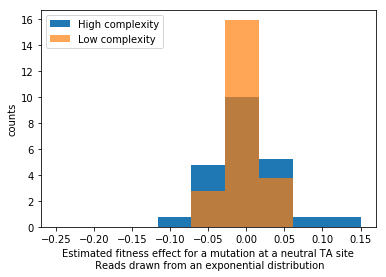

In [250]:
plt.hist(fitness_sc1_exp, bins=np.linspace(-0.25,0.15,10), label='High complexity', density=True)
plt.hist(fitness_sc2_exp, bins=np.linspace(-0.25,0.15,10), label='Low complexity', density=True, alpha=0.7)
plt.xlabel("Estimated fitness effect for a mutation at a neutral TA site\n Reads drawn from an exponential distribution")
plt.legend(loc=0)
plt.ylabel("counts")

Text(0, 0.5, 'counts')

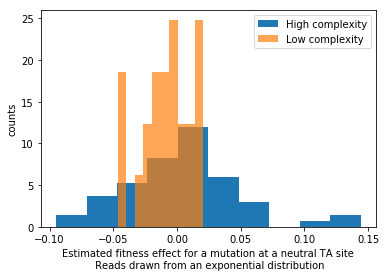

In [251]:
plt.hist(fitness_sc1_exp, bins=10, label='High complexity', density=True)
plt.hist(fitness_sc2_exp, bins=10, label='Low complexity', density=True, alpha=0.7)
plt.xlabel("Estimated fitness effect for a mutation at a neutral TA site\n Reads drawn from an exponential distribution")
plt.legend(loc=0)
plt.ylabel("counts")

In [252]:
filteredsc2 = fitness_sc2_exp[(fitness_sc2_exp>np.median(fitness_sc2_exp)-0.025)&(fitness_sc2_exp<np.median(fitness_sc2_exp)+0.025)]

In [253]:
filteredsc1 = fitness_sc1_exp[(fitness_sc1_exp>np.median(fitness_sc1_exp)-0.025)&(fitness_sc1_exp<np.median(fitness_sc1_exp)+0.025)]

In [254]:
np.std(filteredsc2)/np.sqrt(np.size(filteredsc2))

0.0028819928754391182

In [255]:
np.std(filteredsc1)/np.sqrt(np.size(filteredsc1))

0.0024043224367626846